# Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import re
import sys

import time
import torch
import torch.hub
import torch.nn

import random

from pred_utils import balanced_over_sampling

In [2]:
if torch.cuda.is_available():
    device = "cuda:0"  ###### "cuda: 1"
else:
    device = "cpu"

In [3]:
gut_16s_df = pd.read_table("./data/gut_16s_abundance.txt", index_col=0)
metabolome_df = pd.read_table("./data/metabolome_abundance.txt", index_col=0)
metabolome_df = metabolome_df.drop(columns=['SubjectID', 'CollectionDate', 'CL1', 'CL2', 'CL3', 'CL4'])
subjects = pd.read_csv("./data/subjects.csv", na_values="NA")

In [4]:
from sklearn.preprocessing import StandardScaler
gut_16s_df_array = StandardScaler().fit_transform(gut_16s_df)
gut_16s_df = pd.DataFrame(gut_16s_df_array, index=gut_16s_df.index, columns=gut_16s_df.columns)

metabolome_df_array = StandardScaler().fit_transform(metabolome_df)
metabolome_df = pd.DataFrame(metabolome_df_array, index=metabolome_df.index, columns=metabolome_df.columns)

## Build MLPs

In [5]:
### some parameters used in models
n_out_features = 10

# Training parameters
# Decreasing lr and adding gradient_clip improves stability
lr = 0.001
momentum = 0.9
weight_decay_dict = dict([('IR_IS_classification', 0.01), ('Sex', 0.01), ('Race', 0.01)])
gradient_clip = 3

dropout_dict = dict([('IR_IS_classification', 0.6), ('Sex', 0.6), ('Race', 0.4)])

In [6]:
import torch
import torch.nn as nn
class Classifier(torch.nn.Module):
    def __init__(self, net_structure, n_out_features, label_dim, dropout_rate):
        super(Classifier, self).__init__()
        genenet_fcs = []
        structure = net_structure
        genenet_in_shape = structure[0]
        for i, genenet_n_hidden_nodes in enumerate(structure[1:]):
            genenet_fcs.append(torch.nn.Linear(genenet_in_shape, genenet_n_hidden_nodes))
            genenet_fcs.append(torch.nn.BatchNorm1d(genenet_n_hidden_nodes))
            genenet_fcs.append(torch.nn.ReLU6())
            genenet_fcs.append(torch.nn.Dropout(p=dropout_rate))
            genenet_in_shape = genenet_n_hidden_nodes
        genenet_fcs.append(torch.nn.Linear(genenet_in_shape, n_out_features))
        genenet_fcs.append(torch.nn.Linear(n_out_features, label_dim))
        self.genenet_fcs = torch.nn.ModuleList(genenet_fcs)
        
    def forward(self, x):
        genenet_fcs = self.genenet_fcs
        for genenet_fc in genenet_fcs:
            x = genenet_fc(x)
        return x

In [7]:
# train function
from utils_eval import AverageMeter

def train(epoch, classifier, criterion, optimizer, train_loader, device='cuda:0'):
    """
    One epoch training
    """
    
    classifier.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # ===================forward=====================
        outputs = classifier(data)
        loss = criterion(outputs, target)

        # ===================backward=====================
        loss.backward()
        optimizer.step()
    
    return loss

In [8]:
def train_mlp(covariate, gm_data_name, batch_size = 32, n_epoch=500, random_seed=123):
    
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)
    #torch.set_deterministic(True)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_seed)
        
    from pred_utils import balanced_over_sampling
    gut_16s_feat_subj_all = pd.read_pickle('./feature_data/{}/all/gut_16s_feat_subj_all.pkl'.format(covariate))
    
    gut_16s_feat_subj_train = pd.read_pickle('./feature_data/{}/train/gut_16s_feat_subj_train.pkl'.format(covariate))
    metabolome_feat_subj_train = pd.read_pickle('./feature_data/{}/train/metabolome_feat_subj_train.pkl'.format(covariate))

    gut_16s_feat_subj_val = pd.read_pickle('./feature_data/{}/val/gut_16s_feat_subj_val.pkl'.format(covariate))
    metabolome_feat_subj_val = pd.read_pickle('./feature_data/{}/val/metabolome_feat_subj_val.pkl'.format(covariate))

    gut_16s_feat_subj_test = pd.read_pickle('./feature_data/{}/test/gut_16s_feat_subj_test.pkl'.format(covariate))
    metabolome_feat_subj_test = pd.read_pickle('./feature_data/{}/test/metabolome_feat_subj_test.pkl'.format(covariate))
    
    indexes_noukn = gut_16s_feat_subj_all.index
    indexes_train = gut_16s_feat_subj_train.index
    indexes_val = gut_16s_feat_subj_val.index
    indexes_test = gut_16s_feat_subj_test.index

    X_train_g = np.array(gut_16s_df.loc[indexes_train,:])
    y_train_g = gut_16s_feat_subj_train.loc[:,covariate].values
    X_val_g = np.array(gut_16s_df.loc[indexes_val,:])
    y_val_g = gut_16s_feat_subj_val.loc[:,covariate].values
    X_test_g = np.array(gut_16s_df.loc[indexes_test,:])
    y_test_g = gut_16s_feat_subj_test.loc[:,covariate].values

    X_train_m = np.array(metabolome_df.loc[indexes_train,:])
    y_train_m = metabolome_feat_subj_train.loc[:,covariate].values
    X_val_m = np.array(metabolome_df.loc[indexes_val,:])
    y_val_m = metabolome_feat_subj_val.loc[:,covariate].values
    X_test_m = np.array(metabolome_df.loc[indexes_test,:])
    y_test_m = metabolome_feat_subj_test.loc[:,covariate].values

    if gm_data_name=='gut_16s':
        X_train, X_val, X_test, y_train, y_val, y_test = X_train_g, X_val_g, X_test_g, y_train_g, y_val_g, y_test_g
        net_structure = [gut_16s_df.shape[1], 64, 32]
    
    elif gm_data_name=='metabolome':
        X_train, X_val, X_test, y_train, y_val, y_test = X_train_m, X_val_m, X_test_m, y_train_m, y_val_m, y_test_m
        net_structure = [metabolome_df.shape[1], 256, 64]
        
    X_balanced_train, y_balanced_train = balanced_over_sampling(X_train, y_train)

    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(gut_16s_feat_subj_all[covariate])
    y_balanced_train_le = le.transform(y_balanced_train)
    y_val_le = le.transform(y_val)
    y_test_le = le.transform(y_test)
    classes = le.classes_
    label_dim = len(classes)

    train_data = torch.utils.data.TensorDataset(torch.tensor(np.array(X_balanced_train, dtype='float32')), 
                                                torch.LongTensor(y_balanced_train_le))
    val_data = torch.utils.data.TensorDataset(torch.tensor(np.array(X_val, dtype='float32')), 
                                              torch.LongTensor(y_val_le))

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0)
    classifier = Classifier(net_structure = net_structure, n_out_features=n_out_features, 
                            label_dim=label_dim, dropout_rate=dropout_dict[covariate]).to(device)
    criterion = nn.CrossEntropyLoss() # nn.CrossEntropyLoss combines log_softmax and NLLLoss
    optimizer = torch.optim.SGD(classifier.parameters(), lr=lr, momentum=momentum, 
                                  weight_decay = weight_decay_dict[covariate])
    
    # trian
    # =========================
    hist = dict()
    hist['train_loss'] = []
    hist['val_loss'] = []

    for epoch in range(n_epoch):
        # Train
        train_loss = \
            train(epoch, classifier, criterion, optimizer, train_loader, device=device)
        hist['train_loss'].append(train_loss.cpu().detach().numpy())

        # Val
        classifier.eval()

        with torch.no_grad():
            for idx, (data, target) in enumerate(val_loader):
                data, target = data.to(device), target.to(device)

                # ===================forward=====================
                outputs = classifier(data)
                val_loss = criterion(outputs, target)

            hist['val_loss'].append(val_loss.cpu().detach().numpy())
        print('Epoch {} \ttrain_loss\t{}\tval_loss\t{}'.format(epoch, train_loss, val_loss))

    os.makedirs('./models/MLP_random_seed_{}/{}'.format(random_seed, gm_data_name), exist_ok=True)
    
    torch.save({
                'epoch': n_epoch,
                'model_state_dict': classifier.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history': hist
                }, './models/MLP_random_seed_{}/{}/model_{}.pth'.format(random_seed, gm_data_name, covariate))
    return classifier, optimizer, hist, (indexes_noukn, indexes_train, indexes_val, indexes_test), le

In [9]:
def plot_mlp_loss(hist, covariate, gm_data_name, random_seed=123):

    fig = plt.figure(figsize=(16,8))

    plt.plot(np.arange(len(hist['train_loss'])), hist['train_loss'], 
                 label='Training loss', alpha=0.8)

    plt.plot(np.arange(len(hist['val_loss'])), hist['val_loss'], 
                 label='Validation loss', alpha=0.8)

    plt.xlabel('Epoches', fontsize=20)
    plt.xticks(fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.yticks(fontsize=20)
    plt.title('MLP Loss for {} (Covariate = {})'.format(gm_data_name, covariate), fontsize=20)
    plt.legend(fontsize=20)
    
    save_folder = './figures/MLP_random_seed_{}/{}/{}'.format(random_seed, gm_data_name, covariate)
    os.makedirs(save_folder, exist_ok=True)
    fig.savefig(os.path.join(save_folder, 'MLP_train_val_losses.pdf'))
    plt.show()

## Store 10-dim feature from the 2nd to the last layer

In [10]:
# features for all samples
def g_10dim_features(index, classifier):
    input_g = gut_16s_df.loc[index,:]
    layer_len = len(list(classifier.modules())[1])
    # Forward
    classifier.eval()
    with torch.no_grad():
        _g_feature = torch.tensor(input_g).float()
        for i, _module in enumerate(list(classifier.modules())[1][:(layer_len-1)]): # enumerate in ModuleList
            _g_feature = _module(torch.tensor([_g_feature.squeeze().cpu().numpy()]).float().to(device))

    _g_feature = _g_feature.squeeze().cpu().numpy()
    return _g_feature

def m_10dim_features(index, classifier):
    input_m = metabolome_df.loc[index,:]
    layer_len = len(list(classifier.modules())[1])
    # Forward
    classifier.eval()
    with torch.no_grad():
        _m_feature = torch.tensor(input_m).float()
        for i, _module in enumerate(list(classifier.modules())[1][:(layer_len-1)]): # enumerate in ModuleList
            _m_feature = _module(torch.tensor([_m_feature.squeeze().cpu().numpy()]).float().to(device))

    _m_feature = _m_feature.squeeze().cpu().numpy()
    return _m_feature

In [11]:
def store_embedding_mlp(index, covariate, classifier_g, classifier_m, which_dataset, random_seed=123):
    """
    which_dataset: {'all', 'train', 'val', 'test'}
    """
    feat_gut_16s = pd.DataFrame(index=index, columns=["Feature {}".format(i) for i in range(n_out_features)])
    for i in range(len(index)):
        feat_gut_16s.iloc[i,:] = g_10dim_features(index[i], classifier_g)
    feat_gut_16s['SubjectID'] = [feat_gut_16s.index[i][0:7] for i in range(len(index))]
    gut_16s_feat_subj = pd.merge(left=feat_gut_16s, right=subjects, how='left', on='SubjectID')
    gut_16s_feat_subj.index = feat_gut_16s.index

    feat_metabolome = pd.DataFrame(index=index, columns=["Feature {}".format(i) for i in range(n_out_features)])
    for i in range(len(index)):
        feat_metabolome.iloc[i,:] = m_10dim_features(index[i], classifier_m)
    feat_metabolome['SubjectID'] = [feat_metabolome.index[i][0:7] for i in range(len(index))]
    metabolome_feat_subj = pd.merge(left=feat_metabolome, right=subjects, how='left', on='SubjectID')
    metabolome_feat_subj.index = feat_metabolome.index

    feat_gut_16s = feat_gut_16s.drop(columns='SubjectID')
    feat_metabolome = feat_metabolome.drop(columns='SubjectID')

    save_folder = './feature_data/MLP_10dim_random_seed_{}/{}/{}'.format(random_seed, covariate, which_dataset)
    
    os.makedirs(save_folder, exist_ok=True)
        
    feat_gut_16s.to_pickle(os.path.join(save_folder, 'feat_gut_16s_{}.pkl'.format(which_dataset)))
    feat_metabolome.to_pickle(os.path.join(save_folder, 'feat_metabolome_{}.pkl'.format(which_dataset)))
    gut_16s_feat_subj.to_pickle(os.path.join(save_folder, 'gut_16s_feat_subj_{}.pkl'.format(which_dataset)))
    metabolome_feat_subj.to_pickle(os.path.join(save_folder, 'metabolome_feat_subj_{}.pkl'.format(which_dataset)))

## Train and forward

### 1) IR_IS_classification

In [12]:
classifier_g_iris, optimizer_g_iris, hist_g_iris, index_set_iris, le_iris =\
    train_mlp('IR_IS_classification', 'gut_16s', random_seed=123)

Epoch 0 	train_loss	0.8141074776649475	val_loss	0.6937091946601868
Epoch 1 	train_loss	0.6328426003456116	val_loss	0.6952013969421387
Epoch 2 	train_loss	0.627061665058136	val_loss	0.6893202066421509
Epoch 3 	train_loss	0.6974139213562012	val_loss	0.6766509413719177
Epoch 4 	train_loss	0.7396314740180969	val_loss	0.670842707157135
Epoch 5 	train_loss	0.7158917784690857	val_loss	0.6656551361083984
Epoch 6 	train_loss	0.6509880423545837	val_loss	0.6641851663589478
Epoch 7 	train_loss	0.5816053748130798	val_loss	0.6638140678405762
Epoch 8 	train_loss	0.6209818720817566	val_loss	0.6616288423538208
Epoch 9 	train_loss	0.7113420963287354	val_loss	0.6609616875648499
Epoch 10 	train_loss	0.664811372756958	val_loss	0.6591759324073792
Epoch 11 	train_loss	0.6842696070671082	val_loss	0.6518037915229797
Epoch 12 	train_loss	0.5833588242530823	val_loss	0.6502127647399902
Epoch 13 	train_loss	0.6792845129966736	val_loss	0.6475422382354736
Epoch 14 	train_loss	0.7190253734588623	val_loss	0.6422832608

Epoch 121 	train_loss	0.6835084557533264	val_loss	0.32571396231651306
Epoch 122 	train_loss	0.3302067816257477	val_loss	0.33164799213409424
Epoch 123 	train_loss	0.6582080125808716	val_loss	0.3306892514228821
Epoch 124 	train_loss	0.31931158900260925	val_loss	0.3360637128353119
Epoch 125 	train_loss	0.41142523288726807	val_loss	0.3276987671852112
Epoch 126 	train_loss	0.2500304877758026	val_loss	0.32771265506744385
Epoch 127 	train_loss	0.47588786482810974	val_loss	0.32933327555656433
Epoch 128 	train_loss	0.26045218110084534	val_loss	0.3252519369125366
Epoch 129 	train_loss	0.3123464286327362	val_loss	0.327207088470459
Epoch 130 	train_loss	0.2502395212650299	val_loss	0.32084524631500244
Epoch 131 	train_loss	0.5049450993537903	val_loss	0.3186873197555542
Epoch 132 	train_loss	0.21512271463871002	val_loss	0.3244280219078064
Epoch 133 	train_loss	0.6117348670959473	val_loss	0.3177456259727478
Epoch 134 	train_loss	0.5035086870193481	val_loss	0.3222815692424774
Epoch 135 	train_loss	0.3

Epoch 241 	train_loss	0.12874634563922882	val_loss	0.3144562542438507
Epoch 242 	train_loss	0.6784963607788086	val_loss	0.3136698603630066
Epoch 243 	train_loss	0.42183592915534973	val_loss	0.31843477487564087
Epoch 244 	train_loss	0.35755419731140137	val_loss	0.31577569246292114
Epoch 245 	train_loss	0.13593827188014984	val_loss	0.3119642436504364
Epoch 246 	train_loss	0.20913411676883698	val_loss	0.30660921335220337
Epoch 247 	train_loss	1.223753571510315	val_loss	0.2981851100921631
Epoch 248 	train_loss	0.40379515290260315	val_loss	0.3053199052810669
Epoch 249 	train_loss	0.16963674128055573	val_loss	0.3113926649093628
Epoch 250 	train_loss	0.572279691696167	val_loss	0.31042930483818054
Epoch 251 	train_loss	0.16063551604747772	val_loss	0.3153240382671356
Epoch 252 	train_loss	0.1551877111196518	val_loss	0.30693677067756653
Epoch 253 	train_loss	0.2316277027130127	val_loss	0.3069557547569275
Epoch 254 	train_loss	0.4180566966533661	val_loss	0.3039029538631439
Epoch 255 	train_loss	0

Epoch 359 	train_loss	0.5578994154930115	val_loss	0.30104056000709534
Epoch 360 	train_loss	0.6984186768531799	val_loss	0.3204360008239746
Epoch 361 	train_loss	0.39351892471313477	val_loss	0.3272162079811096
Epoch 362 	train_loss	0.1702183485031128	val_loss	0.331426739692688
Epoch 363 	train_loss	0.32706770300865173	val_loss	0.3342703580856323
Epoch 364 	train_loss	0.2071922868490219	val_loss	0.34253036975860596
Epoch 365 	train_loss	0.3048131465911865	val_loss	0.35059452056884766
Epoch 366 	train_loss	0.07056006044149399	val_loss	0.3455696702003479
Epoch 367 	train_loss	0.7271848320960999	val_loss	0.3402044177055359
Epoch 368 	train_loss	0.14606930315494537	val_loss	0.32316136360168457
Epoch 369 	train_loss	0.4156974256038666	val_loss	0.33033010363578796
Epoch 370 	train_loss	0.22074663639068604	val_loss	0.33640816807746887
Epoch 371 	train_loss	0.08444245904684067	val_loss	0.34069278836250305
Epoch 372 	train_loss	0.28864094614982605	val_loss	0.3183698058128357
Epoch 373 	train_loss

Epoch 478 	train_loss	0.3137805461883545	val_loss	0.33820897340774536
Epoch 479 	train_loss	0.44504567980766296	val_loss	0.31924718618392944
Epoch 480 	train_loss	0.4787139594554901	val_loss	0.31830736994743347
Epoch 481 	train_loss	0.17777897417545319	val_loss	0.3248386085033417
Epoch 482 	train_loss	0.33723798394203186	val_loss	0.3319522738456726
Epoch 483 	train_loss	0.36973726749420166	val_loss	0.34965166449546814
Epoch 484 	train_loss	0.08744344860315323	val_loss	0.34577691555023193
Epoch 485 	train_loss	0.2027960568666458	val_loss	0.35695934295654297
Epoch 486 	train_loss	0.19892342388629913	val_loss	0.36183130741119385
Epoch 487 	train_loss	0.05178084969520569	val_loss	0.3539203107357025
Epoch 488 	train_loss	0.09902393817901611	val_loss	0.36064010858535767
Epoch 489 	train_loss	0.6051213145256042	val_loss	0.3629262149333954
Epoch 490 	train_loss	0.4255533516407013	val_loss	0.37267810106277466
Epoch 491 	train_loss	0.07626662403345108	val_loss	0.3737558424472809
Epoch 492 	train

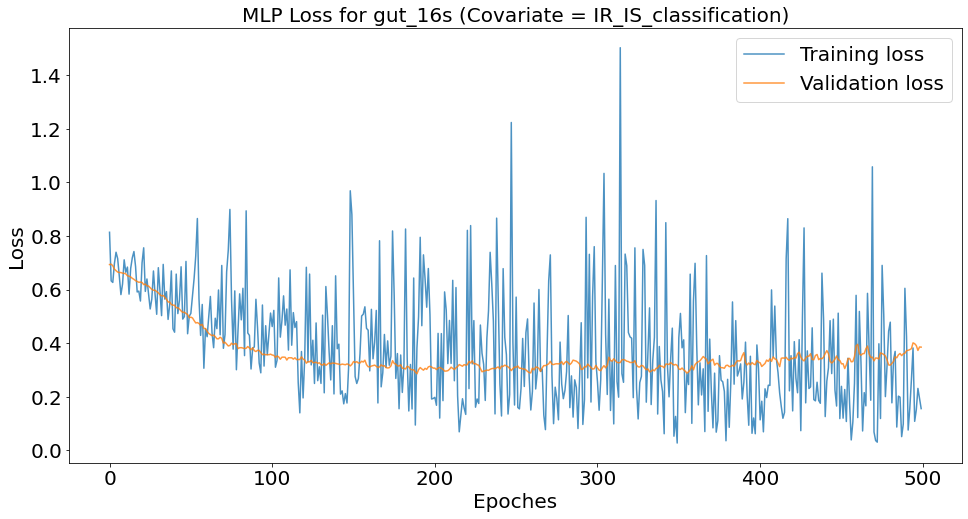

In [13]:
plot_mlp_loss(hist_g_iris, 'IR_IS_classification', 'gut_16s', random_seed=123)

In [14]:
classifier_m_iris, optimizer_m_iris, hist_m_iris, index_set_iris, le_iris =\
    train_mlp('IR_IS_classification', 'metabolome', random_seed=123)

Epoch 0 	train_loss	0.6227973103523254	val_loss	0.6953212022781372
Epoch 1 	train_loss	0.6874892115592957	val_loss	0.689079999923706
Epoch 2 	train_loss	0.6631569266319275	val_loss	0.6832773685455322
Epoch 3 	train_loss	0.6983709931373596	val_loss	0.6794153451919556
Epoch 4 	train_loss	0.669647216796875	val_loss	0.6715353727340698
Epoch 5 	train_loss	0.6343347430229187	val_loss	0.664401650428772
Epoch 6 	train_loss	0.6332299113273621	val_loss	0.6626816391944885
Epoch 7 	train_loss	0.6215129494667053	val_loss	0.6576457023620605
Epoch 8 	train_loss	0.673577606678009	val_loss	0.6499803066253662
Epoch 9 	train_loss	0.6691620349884033	val_loss	0.6452040076255798
Epoch 10 	train_loss	0.6681421399116516	val_loss	0.6375765204429626
Epoch 11 	train_loss	0.630596935749054	val_loss	0.63038170337677
Epoch 12 	train_loss	0.5978014469146729	val_loss	0.6261575222015381
Epoch 13 	train_loss	0.49742093682289124	val_loss	0.6149051189422607
Epoch 14 	train_loss	0.5879518389701843	val_loss	0.6060168743133

Epoch 120 	train_loss	0.002427036641165614	val_loss	0.0918067991733551
Epoch 121 	train_loss	0.020428471267223358	val_loss	0.08577105402946472
Epoch 122 	train_loss	0.002471815561875701	val_loss	0.09690135717391968
Epoch 123 	train_loss	0.01022858452051878	val_loss	0.08306337147951126
Epoch 124 	train_loss	0.0077029038220644	val_loss	0.07353195548057556
Epoch 125 	train_loss	0.00886327400803566	val_loss	0.08758734166622162
Epoch 126 	train_loss	0.012106172740459442	val_loss	0.075154609978199
Epoch 127 	train_loss	0.014482010155916214	val_loss	0.06886060535907745
Epoch 128 	train_loss	0.057379093021154404	val_loss	0.07956776022911072
Epoch 129 	train_loss	0.040125247091054916	val_loss	0.07001861929893494
Epoch 130 	train_loss	0.03467470780014992	val_loss	0.0909489095211029
Epoch 131 	train_loss	0.010127079673111439	val_loss	0.07848325371742249
Epoch 132 	train_loss	0.009593215771019459	val_loss	0.08096030354499817
Epoch 133 	train_loss	0.001988820033147931	val_loss	0.06903920322656631
E

Epoch 235 	train_loss	0.020127033814787865	val_loss	0.07109402120113373
Epoch 236 	train_loss	0.004709878470748663	val_loss	0.07373299449682236
Epoch 237 	train_loss	0.21397177875041962	val_loss	0.10443085432052612
Epoch 238 	train_loss	0.01005595177412033	val_loss	0.0756494402885437
Epoch 239 	train_loss	0.003964538220316172	val_loss	0.08389078825712204
Epoch 240 	train_loss	0.004787917248904705	val_loss	0.0836973488330841
Epoch 241 	train_loss	0.012855485081672668	val_loss	0.08626362681388855
Epoch 242 	train_loss	0.006848044693470001	val_loss	0.09277672320604324
Epoch 243 	train_loss	0.004435355309396982	val_loss	0.09525229036808014
Epoch 244 	train_loss	0.0022055888548493385	val_loss	0.0818958431482315
Epoch 245 	train_loss	0.2589704692363739	val_loss	0.07519993185997009
Epoch 246 	train_loss	0.0024557902943342924	val_loss	0.09161730855703354
Epoch 247 	train_loss	0.053919240832328796	val_loss	0.09990774095058441
Epoch 248 	train_loss	0.003530183807015419	val_loss	0.096435502171516

Epoch 350 	train_loss	0.008401361294090748	val_loss	0.10350396484136581
Epoch 351 	train_loss	0.04359199479222298	val_loss	0.11694853752851486
Epoch 352 	train_loss	0.004036083817481995	val_loss	0.08335188776254654
Epoch 353 	train_loss	0.003580956719815731	val_loss	0.09134438633918762
Epoch 354 	train_loss	0.015602984465658665	val_loss	0.06984839588403702
Epoch 355 	train_loss	0.007695404812693596	val_loss	0.06201992556452751
Epoch 356 	train_loss	0.008957424201071262	val_loss	0.06173710152506828
Epoch 357 	train_loss	0.06272611767053604	val_loss	0.09315454959869385
Epoch 358 	train_loss	0.030231056734919548	val_loss	0.10155975073575974
Epoch 359 	train_loss	0.0029965711291879416	val_loss	0.07699887454509735
Epoch 360 	train_loss	0.07484418153762817	val_loss	0.11648163199424744
Epoch 361 	train_loss	0.006543729454278946	val_loss	0.07547427713871002
Epoch 362 	train_loss	0.11239975690841675	val_loss	0.07965601235628128
Epoch 363 	train_loss	0.01025343406945467	val_loss	0.07263745367527

Epoch 465 	train_loss	0.0022832087706774473	val_loss	0.06654424220323563
Epoch 466 	train_loss	0.005293846596032381	val_loss	0.06514095515012741
Epoch 467 	train_loss	0.0038504181429743767	val_loss	0.0639113336801529
Epoch 468 	train_loss	0.01430489867925644	val_loss	0.07097125053405762
Epoch 469 	train_loss	0.01675950177013874	val_loss	0.07399646937847137
Epoch 470 	train_loss	0.003984477836638689	val_loss	0.07465647161006927
Epoch 471 	train_loss	0.0029320495668798685	val_loss	0.06626775115728378
Epoch 472 	train_loss	0.002332413336262107	val_loss	0.07213135063648224
Epoch 473 	train_loss	0.00920772273093462	val_loss	0.07406948506832123
Epoch 474 	train_loss	0.0058783660642802715	val_loss	0.08114652335643768
Epoch 475 	train_loss	0.004570132587105036	val_loss	0.07564748823642731
Epoch 476 	train_loss	0.0047339643351733685	val_loss	0.07862992584705353
Epoch 477 	train_loss	0.0021014290396124125	val_loss	0.08441412448883057
Epoch 478 	train_loss	0.02744547463953495	val_loss	0.064557366

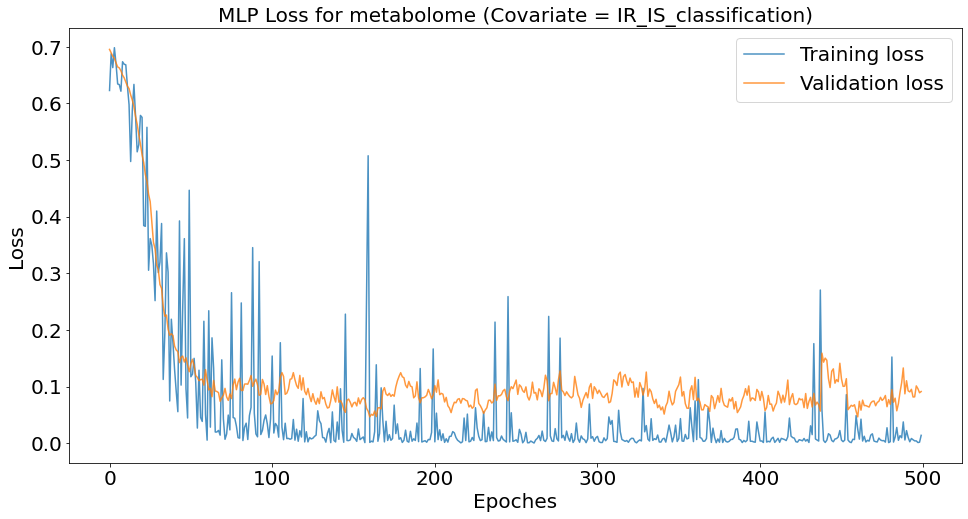

In [15]:
plot_mlp_loss(hist_m_iris, 'IR_IS_classification', 'metabolome', random_seed=123)

In [16]:
### All samples 
store_embedding_mlp(index_set_iris[0], 'IR_IS_classification', classifier_g_iris, classifier_m_iris, 'all',
                   random_seed=123)
### Validation samples only
store_embedding_mlp(index_set_iris[2], 'IR_IS_classification', classifier_g_iris, classifier_m_iris, 'val',
                   random_seed=123)
### Training samples only
store_embedding_mlp(index_set_iris[1], 'IR_IS_classification', classifier_g_iris, classifier_m_iris, 'train',
                   random_seed=123)
### Testing samples only
store_embedding_mlp(index_set_iris[3], 'IR_IS_classification', classifier_g_iris, classifier_m_iris, 'test',
                   random_seed=123)

### 2) Sex

In [17]:
classifier_g_sex, optimizer_g_sex, hist_g_sex, index_set_sex, le_sex = train_mlp('Sex', 'gut_16s', random_seed=123)

Epoch 0 	train_loss	0.8628161549568176	val_loss	0.7114212512969971
Epoch 1 	train_loss	0.6546000838279724	val_loss	0.6979179382324219
Epoch 2 	train_loss	0.6994861960411072	val_loss	0.6896925568580627
Epoch 3 	train_loss	0.7732429504394531	val_loss	0.6849450469017029
Epoch 4 	train_loss	0.7088934183120728	val_loss	0.6781410574913025
Epoch 5 	train_loss	0.6892942190170288	val_loss	0.6809182167053223
Epoch 6 	train_loss	0.7852008938789368	val_loss	0.6738010048866272
Epoch 7 	train_loss	0.6806569695472717	val_loss	0.6762880682945251
Epoch 8 	train_loss	0.706567108631134	val_loss	0.680834949016571
Epoch 9 	train_loss	0.6671145558357239	val_loss	0.675178050994873
Epoch 10 	train_loss	0.701927125453949	val_loss	0.6736993789672852
Epoch 11 	train_loss	0.6197447776794434	val_loss	0.6747915148735046
Epoch 12 	train_loss	0.6674163937568665	val_loss	0.671788215637207
Epoch 13 	train_loss	0.6870991587638855	val_loss	0.6735303997993469
Epoch 14 	train_loss	0.7679691910743713	val_loss	0.672417342662

Epoch 121 	train_loss	0.5451053977012634	val_loss	0.5624131560325623
Epoch 122 	train_loss	0.4544248580932617	val_loss	0.5630311369895935
Epoch 123 	train_loss	0.434482604265213	val_loss	0.5546689033508301
Epoch 124 	train_loss	0.5384010672569275	val_loss	0.5625218152999878
Epoch 125 	train_loss	0.4928480088710785	val_loss	0.570010244846344
Epoch 126 	train_loss	0.4255819022655487	val_loss	0.5678536295890808
Epoch 127 	train_loss	0.4698036015033722	val_loss	0.5684062838554382
Epoch 128 	train_loss	0.5235276222229004	val_loss	0.5552074909210205
Epoch 129 	train_loss	0.4425043761730194	val_loss	0.5519411563873291
Epoch 130 	train_loss	0.4780801832675934	val_loss	0.5601181387901306
Epoch 131 	train_loss	0.41775959730148315	val_loss	0.5463005900382996
Epoch 132 	train_loss	0.4359535276889801	val_loss	0.5478509068489075
Epoch 133 	train_loss	0.5359667539596558	val_loss	0.549847424030304
Epoch 134 	train_loss	0.3783595561981201	val_loss	0.5424324870109558
Epoch 135 	train_loss	0.488575935363

Epoch 241 	train_loss	0.435230553150177	val_loss	0.4953017234802246
Epoch 242 	train_loss	0.3121851980686188	val_loss	0.49595996737480164
Epoch 243 	train_loss	0.3616419732570648	val_loss	0.5315214395523071
Epoch 244 	train_loss	0.36982694268226624	val_loss	0.5171218514442444
Epoch 245 	train_loss	0.4273436963558197	val_loss	0.5205283761024475
Epoch 246 	train_loss	0.33028289675712585	val_loss	0.4822598397731781
Epoch 247 	train_loss	0.29730144143104553	val_loss	0.4684443175792694
Epoch 248 	train_loss	0.37231993675231934	val_loss	0.45125505328178406
Epoch 249 	train_loss	0.32914310693740845	val_loss	0.40627941489219666
Epoch 250 	train_loss	0.337979257106781	val_loss	0.4535093307495117
Epoch 251 	train_loss	0.308695524930954	val_loss	0.4611262083053589
Epoch 252 	train_loss	0.43528732657432556	val_loss	0.4421653747558594
Epoch 253 	train_loss	0.341630220413208	val_loss	0.5015570521354675
Epoch 254 	train_loss	0.3761473000049591	val_loss	0.4773426353931427
Epoch 255 	train_loss	0.54288

Epoch 359 	train_loss	0.1569174975156784	val_loss	0.5252055525779724
Epoch 360 	train_loss	0.19974668323993683	val_loss	0.5216034054756165
Epoch 361 	train_loss	0.40272656083106995	val_loss	0.5256368517875671
Epoch 362 	train_loss	0.3123508393764496	val_loss	0.5088524222373962
Epoch 363 	train_loss	0.2608349621295929	val_loss	0.6309890151023865
Epoch 364 	train_loss	0.29095056653022766	val_loss	0.6267229914665222
Epoch 365 	train_loss	0.29692941904067993	val_loss	0.6041244864463806
Epoch 366 	train_loss	0.24255573749542236	val_loss	0.5397276282310486
Epoch 367 	train_loss	0.4849749207496643	val_loss	0.5532934069633484
Epoch 368 	train_loss	0.43034452199935913	val_loss	0.531166136264801
Epoch 369 	train_loss	0.38986650109291077	val_loss	0.48854902386665344
Epoch 370 	train_loss	0.287861168384552	val_loss	0.5026724934577942
Epoch 371 	train_loss	0.3147355020046234	val_loss	0.4722787141799927
Epoch 372 	train_loss	0.26437142491340637	val_loss	0.4773343503475189
Epoch 373 	train_loss	0.263

Epoch 478 	train_loss	0.1683768332004547	val_loss	0.6236298084259033
Epoch 479 	train_loss	0.2340226173400879	val_loss	0.6506810188293457
Epoch 480 	train_loss	0.13436195254325867	val_loss	0.6720194220542908
Epoch 481 	train_loss	0.3249816596508026	val_loss	0.6819930672645569
Epoch 482 	train_loss	0.2883455455303192	val_loss	0.6331912875175476
Epoch 483 	train_loss	0.4096948802471161	val_loss	0.5742974877357483
Epoch 484 	train_loss	0.5712738633155823	val_loss	0.5620527863502502
Epoch 485 	train_loss	0.421885222196579	val_loss	0.5291169881820679
Epoch 486 	train_loss	0.28556668758392334	val_loss	0.5080257058143616
Epoch 487 	train_loss	0.3117719292640686	val_loss	0.57564777135849
Epoch 488 	train_loss	0.1778375655412674	val_loss	0.6033743023872375
Epoch 489 	train_loss	0.12261269986629486	val_loss	0.5863390564918518
Epoch 490 	train_loss	0.42456722259521484	val_loss	0.5633218884468079
Epoch 491 	train_loss	0.2930975556373596	val_loss	0.5338096022605896
Epoch 492 	train_loss	0.244781270

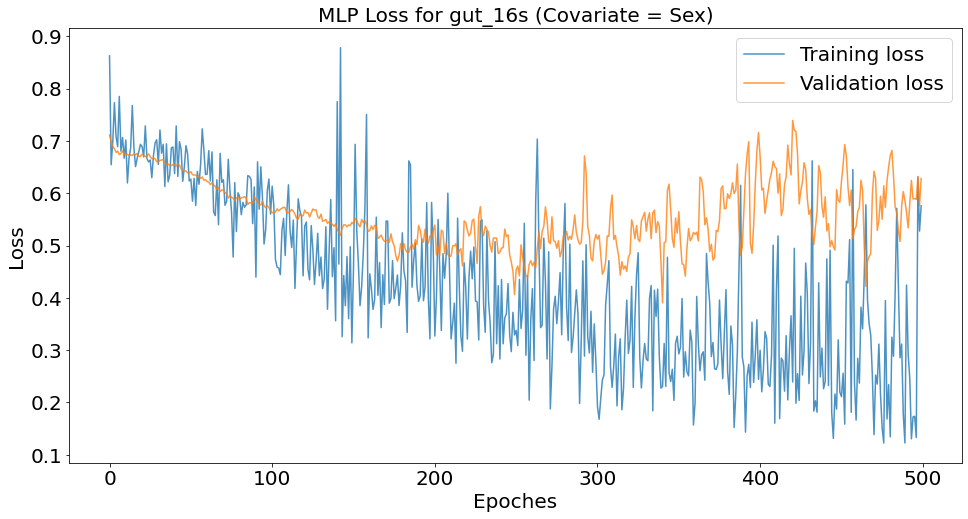

In [18]:
plot_mlp_loss(hist_g_sex, 'Sex', 'gut_16s', random_seed=123)

In [19]:
classifier_m_sex, optimizer_m_sex, hist_m_sex, index_set_sex, le_sex = train_mlp('Sex', 'metabolome', random_seed=123)

Epoch 0 	train_loss	0.6999245882034302	val_loss	0.7016482949256897
Epoch 1 	train_loss	0.7193697690963745	val_loss	0.6978178024291992
Epoch 2 	train_loss	0.6631668210029602	val_loss	0.6907968521118164
Epoch 3 	train_loss	0.7076274752616882	val_loss	0.6854843497276306
Epoch 4 	train_loss	0.6540635824203491	val_loss	0.6775872111320496
Epoch 5 	train_loss	0.6343902349472046	val_loss	0.6700677275657654
Epoch 6 	train_loss	0.653160572052002	val_loss	0.660539448261261
Epoch 7 	train_loss	0.6680291295051575	val_loss	0.6491740345954895
Epoch 8 	train_loss	0.5596193671226501	val_loss	0.6373270750045776
Epoch 9 	train_loss	0.5969157218933105	val_loss	0.6197898983955383
Epoch 10 	train_loss	0.5788332223892212	val_loss	0.6025751829147339
Epoch 11 	train_loss	0.5598515868186951	val_loss	0.5786172151565552
Epoch 12 	train_loss	0.5040509104728699	val_loss	0.5532532334327698
Epoch 13 	train_loss	0.45149537920951843	val_loss	0.5262125134468079
Epoch 14 	train_loss	0.37873587012290955	val_loss	0.5007499

Epoch 120 	train_loss	0.014582215808331966	val_loss	0.2032330185174942
Epoch 121 	train_loss	0.0037123665679246187	val_loss	0.18959344923496246
Epoch 122 	train_loss	0.004775476176291704	val_loss	0.19934631884098053
Epoch 123 	train_loss	0.012440400198101997	val_loss	0.18916238844394684
Epoch 124 	train_loss	0.004215842112898827	val_loss	0.18386347591876984
Epoch 125 	train_loss	0.008568271063268185	val_loss	0.1799972504377365
Epoch 126 	train_loss	0.007044991943985224	val_loss	0.19145117700099945
Epoch 127 	train_loss	0.010731612332165241	val_loss	0.19057883322238922
Epoch 128 	train_loss	0.006317599676549435	val_loss	0.17369753122329712
Epoch 129 	train_loss	0.009406411089003086	val_loss	0.1953287124633789
Epoch 130 	train_loss	0.004290237091481686	val_loss	0.18067817389965057
Epoch 131 	train_loss	0.020712852478027344	val_loss	0.2079136222600937
Epoch 132 	train_loss	0.0052459463477134705	val_loss	0.1863083392381668
Epoch 133 	train_loss	0.0039037580136209726	val_loss	0.211649954319

Epoch 236 	train_loss	0.005135984625667334	val_loss	0.14481304585933685
Epoch 237 	train_loss	0.0036657482851296663	val_loss	0.16250869631767273
Epoch 238 	train_loss	0.005680430214852095	val_loss	0.15993988513946533
Epoch 239 	train_loss	0.009687384590506554	val_loss	0.13707862794399261
Epoch 240 	train_loss	0.07369635999202728	val_loss	0.17440436780452728
Epoch 241 	train_loss	0.0031417955178767443	val_loss	0.15220291912555695
Epoch 242 	train_loss	0.008085369132459164	val_loss	0.13370095193386078
Epoch 243 	train_loss	0.004702492151409388	val_loss	0.12759746611118317
Epoch 244 	train_loss	0.003930702805519104	val_loss	0.13589675724506378
Epoch 245 	train_loss	0.02296006865799427	val_loss	0.1461436003446579
Epoch 246 	train_loss	0.004652711097151041	val_loss	0.16188865900039673
Epoch 247 	train_loss	0.0032569740433245897	val_loss	0.14888259768486023
Epoch 248 	train_loss	0.0060624415054917336	val_loss	0.1729630082845688
Epoch 249 	train_loss	0.003555676667019725	val_loss	0.1437366157

Epoch 352 	train_loss	0.003790907096117735	val_loss	0.11441865563392639
Epoch 353 	train_loss	0.019072098657488823	val_loss	0.1387723833322525
Epoch 354 	train_loss	0.010763862170279026	val_loss	0.14828257262706757
Epoch 355 	train_loss	0.01739959977567196	val_loss	0.105856753885746
Epoch 356 	train_loss	0.004127925261855125	val_loss	0.1053294762969017
Epoch 357 	train_loss	0.006798261310905218	val_loss	0.1316840797662735
Epoch 358 	train_loss	0.00861811451613903	val_loss	0.14516213536262512
Epoch 359 	train_loss	0.005648922175168991	val_loss	0.1564939022064209
Epoch 360 	train_loss	0.0065346211194992065	val_loss	0.12139112502336502
Epoch 361 	train_loss	0.007548694033175707	val_loss	0.14213310182094574
Epoch 362 	train_loss	0.00827142782509327	val_loss	0.12080248445272446
Epoch 363 	train_loss	0.01091833133250475	val_loss	0.1366618573665619
Epoch 364 	train_loss	0.00650006765499711	val_loss	0.13657061755657196
Epoch 365 	train_loss	0.009779131971299648	val_loss	0.12223700433969498
Epo

Epoch 468 	train_loss	0.009554341435432434	val_loss	0.09647897630929947
Epoch 469 	train_loss	0.005231255199760199	val_loss	0.10589977353811264
Epoch 470 	train_loss	0.005597354378551245	val_loss	0.11531589180231094
Epoch 471 	train_loss	0.011877177283167839	val_loss	0.12316995859146118
Epoch 472 	train_loss	0.010932196862995625	val_loss	0.12725673615932465
Epoch 473 	train_loss	0.009725901298224926	val_loss	0.1130199208855629
Epoch 474 	train_loss	0.010991410352289677	val_loss	0.14708192646503448
Epoch 475 	train_loss	0.006329482886940241	val_loss	0.17099274694919586
Epoch 476 	train_loss	0.0032595968805253506	val_loss	0.14652098715305328
Epoch 477 	train_loss	0.00748645281419158	val_loss	0.16103991866111755
Epoch 478 	train_loss	0.004215724766254425	val_loss	0.15576986968517303
Epoch 479 	train_loss	0.021225273609161377	val_loss	0.159925177693367
Epoch 480 	train_loss	0.012226415798068047	val_loss	0.16907958686351776
Epoch 481 	train_loss	0.008376318030059338	val_loss	0.1234751343727

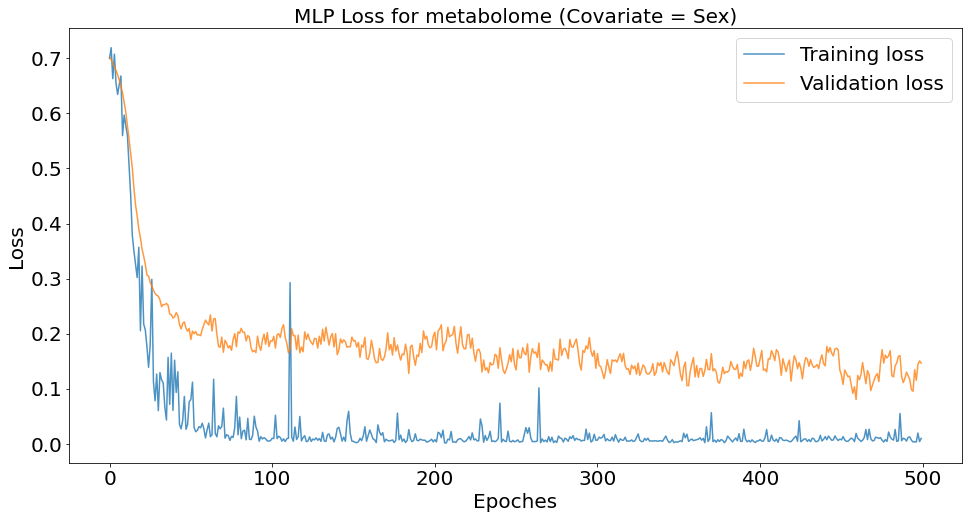

In [20]:
plot_mlp_loss(hist_m_sex, 'Sex', 'metabolome', random_seed=123)

In [21]:
### All samples 
store_embedding_mlp(index_set_sex[0], 'Sex', classifier_g_sex, classifier_m_sex, 'all',
                   random_seed=123)
### Validation samples only
store_embedding_mlp(index_set_sex[2], 'Sex', classifier_g_sex, classifier_m_sex, 'val',
                   random_seed=123)
### Training samples only
store_embedding_mlp(index_set_sex[1], 'Sex', classifier_g_sex, classifier_m_sex, 'train',
                   random_seed=123)
### Testing samples only
store_embedding_mlp(index_set_sex[3], 'Sex', classifier_g_sex, classifier_m_sex, 'test',
                   random_seed=123)

### 3) Race

In [22]:
classifier_g_race, optimizer_g_race, hist_g_race, index_set_race, le_race = train_mlp('Race', 'gut_16s', random_seed=123)

Epoch 0 	train_loss	1.380536437034607	val_loss	1.4697397947311401
Epoch 1 	train_loss	1.5313454866409302	val_loss	1.4533216953277588
Epoch 2 	train_loss	1.2490473985671997	val_loss	1.4364529848098755
Epoch 3 	train_loss	1.3096287250518799	val_loss	1.4099541902542114
Epoch 4 	train_loss	1.2382338047027588	val_loss	1.399285078048706
Epoch 5 	train_loss	1.2496635913848877	val_loss	1.4241353273391724
Epoch 6 	train_loss	1.0683772563934326	val_loss	1.386315941810608
Epoch 7 	train_loss	0.8868045806884766	val_loss	1.4084117412567139
Epoch 8 	train_loss	1.2203519344329834	val_loss	1.4293054342269897
Epoch 9 	train_loss	1.332459568977356	val_loss	1.3909156322479248
Epoch 10 	train_loss	0.9529364109039307	val_loss	1.3026522397994995
Epoch 11 	train_loss	1.0240213871002197	val_loss	1.3070451021194458
Epoch 12 	train_loss	0.7627215385437012	val_loss	1.2777750492095947
Epoch 13 	train_loss	1.5142416954040527	val_loss	1.2826523780822754
Epoch 14 	train_loss	1.0118424892425537	val_loss	1.24562442302

Epoch 122 	train_loss	1.271044135093689	val_loss	1.48932945728302
Epoch 123 	train_loss	0.24405989050865173	val_loss	1.581274390220642
Epoch 124 	train_loss	0.38667845726013184	val_loss	1.5357444286346436
Epoch 125 	train_loss	0.24994555115699768	val_loss	1.5976371765136719
Epoch 126 	train_loss	0.387300044298172	val_loss	1.8809596300125122
Epoch 127 	train_loss	0.2869350016117096	val_loss	1.8235931396484375
Epoch 128 	train_loss	0.1247340589761734	val_loss	1.6088124513626099
Epoch 129 	train_loss	0.6479488015174866	val_loss	1.7025833129882812
Epoch 130 	train_loss	1.0054177045822144	val_loss	1.6470999717712402
Epoch 131 	train_loss	0.28838878870010376	val_loss	1.4770240783691406
Epoch 132 	train_loss	0.27384141087532043	val_loss	1.450089931488037
Epoch 133 	train_loss	0.18569524586200714	val_loss	1.5907871723175049
Epoch 134 	train_loss	0.7677560448646545	val_loss	1.5341346263885498
Epoch 135 	train_loss	0.3721933662891388	val_loss	1.4221168756484985
Epoch 136 	train_loss	0.8954902291

Epoch 242 	train_loss	0.28598034381866455	val_loss	1.9242148399353027
Epoch 243 	train_loss	0.6437617540359497	val_loss	1.7140644788742065
Epoch 244 	train_loss	0.20848968625068665	val_loss	1.6257083415985107
Epoch 245 	train_loss	0.3627609610557556	val_loss	1.785077691078186
Epoch 246 	train_loss	0.2032761424779892	val_loss	1.6063069105148315
Epoch 247 	train_loss	0.028255313634872437	val_loss	1.63335382938385
Epoch 248 	train_loss	0.49487876892089844	val_loss	1.8787907361984253
Epoch 249 	train_loss	0.28009405732154846	val_loss	1.7646232843399048
Epoch 250 	train_loss	0.2465444952249527	val_loss	1.6777396202087402
Epoch 251 	train_loss	0.7172102928161621	val_loss	1.7388083934783936
Epoch 252 	train_loss	0.038892898708581924	val_loss	1.7124375104904175
Epoch 253 	train_loss	0.056525517255067825	val_loss	1.6786003112792969
Epoch 254 	train_loss	0.5264427065849304	val_loss	1.6320637464523315
Epoch 255 	train_loss	0.16295790672302246	val_loss	1.3490389585494995
Epoch 256 	train_loss	0.57

Epoch 362 	train_loss	0.17541372776031494	val_loss	1.8989101648330688
Epoch 363 	train_loss	0.35919779539108276	val_loss	1.6537646055221558
Epoch 364 	train_loss	0.5812795162200928	val_loss	1.6551823616027832
Epoch 365 	train_loss	1.1632006168365479	val_loss	1.7230030298233032
Epoch 366 	train_loss	0.06262076646089554	val_loss	1.9183025360107422
Epoch 367 	train_loss	0.08850616961717606	val_loss	1.7327252626419067
Epoch 368 	train_loss	0.10647711157798767	val_loss	1.6487754583358765
Epoch 369 	train_loss	0.2656494379043579	val_loss	1.9665799140930176
Epoch 370 	train_loss	1.1983915567398071	val_loss	2.075882911682129
Epoch 371 	train_loss	0.3461631238460541	val_loss	1.922016978263855
Epoch 372 	train_loss	0.3943008780479431	val_loss	1.9885300397872925
Epoch 373 	train_loss	0.25841954350471497	val_loss	1.8810442686080933
Epoch 374 	train_loss	0.1639593541622162	val_loss	1.682133436203003
Epoch 375 	train_loss	0.2620832026004791	val_loss	1.9579471349716187
Epoch 376 	train_loss	0.5425021

Epoch 482 	train_loss	0.8387742042541504	val_loss	1.6782959699630737
Epoch 483 	train_loss	0.263334721326828	val_loss	1.5397030115127563
Epoch 484 	train_loss	0.7488993406295776	val_loss	1.923336148262024
Epoch 485 	train_loss	0.0445760041475296	val_loss	1.7486876249313354
Epoch 486 	train_loss	0.10046426951885223	val_loss	1.78289794921875
Epoch 487 	train_loss	1.1600823402404785	val_loss	2.1035051345825195
Epoch 488 	train_loss	0.11035401374101639	val_loss	2.0349442958831787
Epoch 489 	train_loss	0.12182655930519104	val_loss	2.0256521701812744
Epoch 490 	train_loss	1.4531627893447876	val_loss	1.8093994855880737
Epoch 491 	train_loss	1.006271481513977	val_loss	1.657973051071167
Epoch 492 	train_loss	0.6121901869773865	val_loss	1.7231948375701904
Epoch 493 	train_loss	0.24394389986991882	val_loss	1.7588691711425781
Epoch 494 	train_loss	0.12471670657396317	val_loss	1.7094799280166626
Epoch 495 	train_loss	0.03707829490303993	val_loss	1.6997150182724
Epoch 496 	train_loss	0.0911050364375

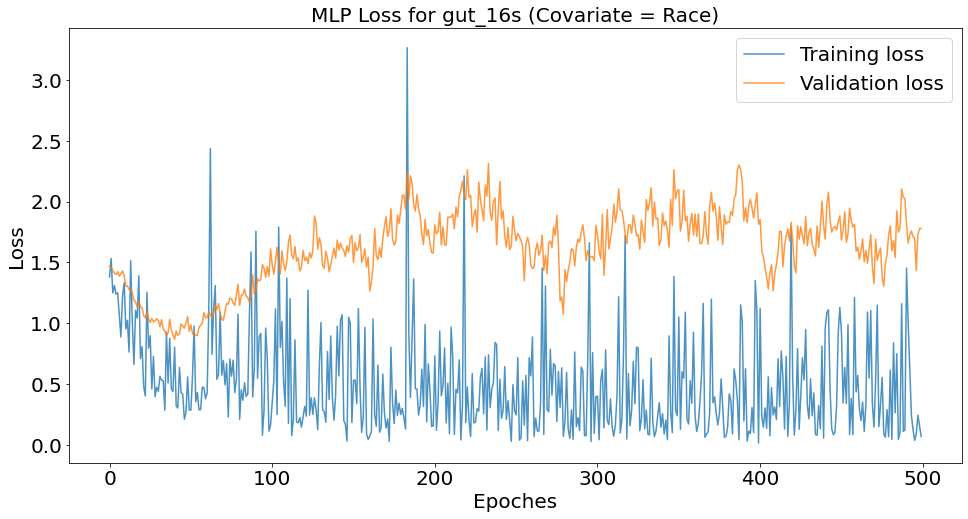

In [23]:
plot_mlp_loss(hist_g_race, 'Race', 'gut_16s', random_seed=123)

In [24]:
classifier_m_race, optimizer_m_race, hist_m_race, index_set_race, le_race = train_mlp('Race', 'metabolome', random_seed=123)

Epoch 0 	train_loss	1.322084665298462	val_loss	1.2241839170455933
Epoch 1 	train_loss	0.9156535863876343	val_loss	1.077218770980835
Epoch 2 	train_loss	0.5643326044082642	val_loss	0.9317807555198669
Epoch 3 	train_loss	1.558547854423523	val_loss	0.7526815533638
Epoch 4 	train_loss	1.2289706468582153	val_loss	0.6596588492393494
Epoch 5 	train_loss	0.3291603922843933	val_loss	0.531865656375885
Epoch 6 	train_loss	0.32749733328819275	val_loss	0.4620567262172699
Epoch 7 	train_loss	0.47645315527915955	val_loss	0.3420257568359375
Epoch 8 	train_loss	0.5472347736358643	val_loss	0.30120232701301575
Epoch 9 	train_loss	0.08127135038375854	val_loss	0.27977168560028076
Epoch 10 	train_loss	0.08519589900970459	val_loss	0.2676544487476349
Epoch 11 	train_loss	0.5952980518341064	val_loss	0.24513192474842072
Epoch 12 	train_loss	0.298149436712265	val_loss	0.2542242705821991
Epoch 13 	train_loss	0.09062100201845169	val_loss	0.2150668054819107
Epoch 14 	train_loss	0.42368677258491516	val_loss	0.211342

Epoch 118 	train_loss	0.03219286724925041	val_loss	0.06072148308157921
Epoch 119 	train_loss	0.0048993611708283424	val_loss	0.04830033704638481
Epoch 120 	train_loss	0.08312981575727463	val_loss	0.07524674385786057
Epoch 121 	train_loss	0.3445422053337097	val_loss	0.05580722913146019
Epoch 122 	train_loss	0.018979553133249283	val_loss	0.05970717966556549
Epoch 123 	train_loss	0.16467218101024628	val_loss	0.03638683259487152
Epoch 124 	train_loss	0.3972169756889343	val_loss	0.05335383117198944
Epoch 125 	train_loss	0.12097711116075516	val_loss	0.04913313314318657
Epoch 126 	train_loss	0.11413396149873734	val_loss	0.05264390632510185
Epoch 127 	train_loss	0.021425731480121613	val_loss	0.05037317052483559
Epoch 128 	train_loss	0.019331684336066246	val_loss	0.050001535564661026
Epoch 129 	train_loss	0.013566713780164719	val_loss	0.05298532173037529
Epoch 130 	train_loss	0.029972976073622704	val_loss	0.059178195893764496
Epoch 131 	train_loss	0.005515096243470907	val_loss	0.0686504244804382

Epoch 234 	train_loss	0.00608210451900959	val_loss	0.10836263000965118
Epoch 235 	train_loss	0.36382967233657837	val_loss	0.12285373359918594
Epoch 236 	train_loss	0.04524323716759682	val_loss	0.10268194228410721
Epoch 237 	train_loss	0.054211195558309555	val_loss	0.11074518412351608
Epoch 238 	train_loss	0.01591322384774685	val_loss	0.1079443022608757
Epoch 239 	train_loss	0.13633783161640167	val_loss	0.08784660696983337
Epoch 240 	train_loss	0.020305046811699867	val_loss	0.08210135251283646
Epoch 241 	train_loss	0.18170365691184998	val_loss	0.08137799054384232
Epoch 242 	train_loss	0.23810984194278717	val_loss	0.08021318912506104
Epoch 243 	train_loss	0.0325210876762867	val_loss	0.06095759943127632
Epoch 244 	train_loss	0.12200406938791275	val_loss	0.06452811509370804
Epoch 245 	train_loss	0.025581173598766327	val_loss	0.07379696518182755
Epoch 246 	train_loss	0.009486335329711437	val_loss	0.07231812179088593
Epoch 247 	train_loss	0.29530343413352966	val_loss	0.06669259816408157
Epoc

Epoch 350 	train_loss	0.064996637403965	val_loss	0.04751884937286377
Epoch 351 	train_loss	0.03779781237244606	val_loss	0.05487462505698204
Epoch 352 	train_loss	0.11145222187042236	val_loss	0.046855710446834564
Epoch 353 	train_loss	0.013136082328855991	val_loss	0.04778902232646942
Epoch 354 	train_loss	0.02224143221974373	val_loss	0.05285079777240753
Epoch 355 	train_loss	0.7513954639434814	val_loss	0.04158643260598183
Epoch 356 	train_loss	0.34835827350616455	val_loss	0.09112978726625443
Epoch 357 	train_loss	0.03960795700550079	val_loss	0.0738031342625618
Epoch 358 	train_loss	0.8077325224876404	val_loss	0.052970364689826965
Epoch 359 	train_loss	0.07303029298782349	val_loss	0.07632177323102951
Epoch 360 	train_loss	0.018553491681814194	val_loss	0.07021123915910721
Epoch 361 	train_loss	0.10776514559984207	val_loss	0.06408894807100296
Epoch 362 	train_loss	0.03592699021100998	val_loss	0.08574371784925461
Epoch 363 	train_loss	0.05867680162191391	val_loss	0.0634886771440506
Epoch 36

Epoch 466 	train_loss	0.0099312299862504	val_loss	0.04615574702620506
Epoch 467 	train_loss	0.6439735889434814	val_loss	0.04294338449835777
Epoch 468 	train_loss	0.1807851642370224	val_loss	0.04553067311644554
Epoch 469 	train_loss	0.3828737735748291	val_loss	0.046293508261442184
Epoch 470 	train_loss	0.0527447871863842	val_loss	0.04886908829212189
Epoch 471 	train_loss	0.04840700328350067	val_loss	0.04359710216522217
Epoch 472 	train_loss	0.01565425843000412	val_loss	0.031367018818855286
Epoch 473 	train_loss	0.0300894808024168	val_loss	0.03401060402393341
Epoch 474 	train_loss	0.5187658071517944	val_loss	0.032953765243291855
Epoch 475 	train_loss	0.01442873664200306	val_loss	0.015790505334734917
Epoch 476 	train_loss	0.03784627839922905	val_loss	0.021728355437517166
Epoch 477 	train_loss	0.013691111467778683	val_loss	0.021263374015688896
Epoch 478 	train_loss	0.0667973980307579	val_loss	0.02055433578789234
Epoch 479 	train_loss	0.04442558437585831	val_loss	0.027251917868852615
Epoch 

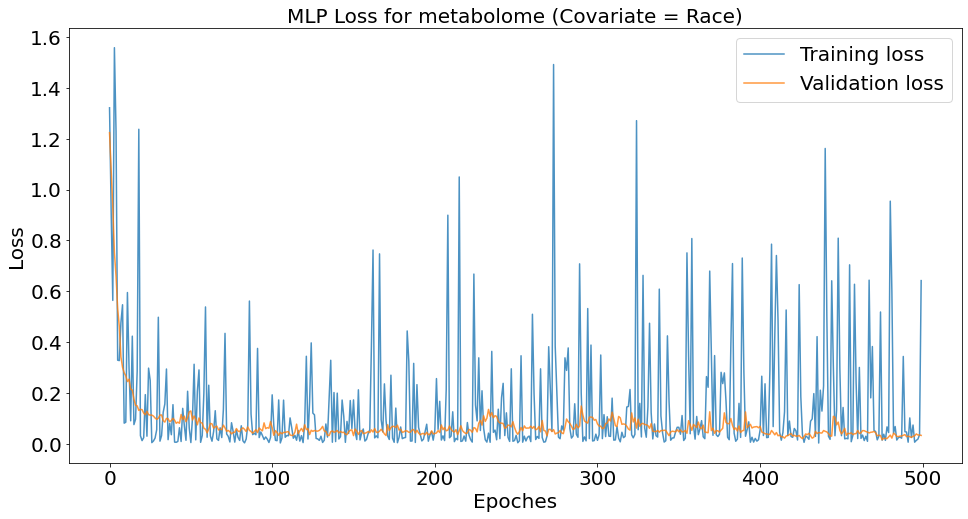

In [25]:
plot_mlp_loss(hist_m_race, 'Race', 'metabolome', random_seed=123)

In [26]:
### All samples 
store_embedding_mlp(index_set_race[0], 'Race', classifier_g_race, classifier_m_race, 'all',
                   random_seed=123)
### Validation samples only
store_embedding_mlp(index_set_race[2], 'Race', classifier_g_race, classifier_m_race, 'val',
                   random_seed=123)
### Training samples only
store_embedding_mlp(index_set_race[1], 'Race', classifier_g_race, classifier_m_race, 'train',
                   random_seed=123)
### Testing samples only
store_embedding_mlp(index_set_race[3], 'Race', classifier_g_race, classifier_m_race, 'test',
                   random_seed=123)

## Prediction

In [27]:
def predict_mlp(covariate, gm_data_name, classifier_g, classifier_m, le):
    
    gut_16s_feat_subj_val = pd.read_pickle('./feature_data/{}/val/gut_16s_feat_subj_val.pkl'.format(covariate))
    metabolome_feat_subj_val = pd.read_pickle('./feature_data/{}/val/metabolome_feat_subj_val.pkl'.format(covariate))

    gut_16s_feat_subj_test = pd.read_pickle('./feature_data/{}/test/gut_16s_feat_subj_test.pkl'.format(covariate))
    metabolome_feat_subj_test = pd.read_pickle('./feature_data/{}/test/metabolome_feat_subj_test.pkl'.format(covariate))
    
    indexes_val = gut_16s_feat_subj_val.index
    indexes_test = gut_16s_feat_subj_test.index
    
    X_val_g = np.array(gut_16s_df.loc[indexes_val,:])
    y_val_g = gut_16s_feat_subj_val.loc[:,covariate].values
    X_test_g = np.array(gut_16s_df.loc[indexes_test,:])
    y_test_g = gut_16s_feat_subj_test.loc[:,covariate].values

    X_val_m = np.array(metabolome_df.loc[indexes_val,:])
    y_val_m = metabolome_feat_subj_val.loc[:,covariate].values
    X_test_m = np.array(metabolome_df.loc[indexes_test,:])
    y_test_m = metabolome_feat_subj_test.loc[:,covariate].values
    
    if gm_data_name=='gut_16s':
        X_val, X_test, y_val, y_test = X_val_g, X_test_g, y_val_g, y_test_g
        classifier = classifier_g
    
    elif gm_data_name=='metabolome':
        X_val, X_test, y_val, y_test = X_val_m, X_test_m, y_val_m, y_test_m
        classifier = classifier_m
    
    classes = le.classes_
    
    classifier.eval()
    with torch.no_grad():
        prediction_val = classifier(torch.tensor(np.array(X_val, dtype='float32')).to(device)).cpu().numpy()
        prediction_test = classifier(torch.tensor(np.array(X_test, dtype='float32')).to(device)).cpu().numpy()
    pred_class_val = classes[nn.Softmax(dim=1)(torch.tensor(prediction_val)).argmax(axis=1)]
    pred_class_test = classes[nn.Softmax(dim=1)(torch.tensor(prediction_test)).argmax(axis=1)]
    accuracy_val = sum(pred_class_val==y_val)/len(pred_class_val)
    accuracy_test = sum(pred_class_test==y_test)/len(pred_class_test)
    return (prediction_val, pred_class_val, accuracy_val), (prediction_test, pred_class_test, accuracy_test)

### 1) IR_IS_classification

In [28]:
(prediction_val_g_iris, pred_class_val_g_iris, accuracy_val_g_iris), \
(prediction_test_g_iris, pred_class_test_g_iris, accuracy_test_g_iris) = \
    predict_mlp('IR_IS_classification', 'gut_16s', classifier_g_iris, classifier_m_iris, le_iris)


In [29]:
(prediction_val_m_iris, pred_class_val_m_iris, accuracy_val_m_iris), \
(prediction_test_m_iris, pred_class_test_m_iris, accuracy_test_m_iris) = \
    predict_mlp('IR_IS_classification', 'metabolome', classifier_g_iris, classifier_m_iris, le_iris)

In [30]:
print('Validation:\nPrediction accuracy for microbiome embedding (MLP; {0}) = {1:.2%}\n'
      'Prediction accuracy for metabolome embedding (MLP; {0}) = {2:.2%}\n\n'
      'Testing:\nPrediction accuracy for microbiome embedding (MLP; {0}) = {3:.2%}\n'
      'Prediction accuracy for metabolome embedding (MLP; {0}) = {4:.2%}'.\
      format('IR_IS_classification', accuracy_val_g_iris, accuracy_val_m_iris, accuracy_test_g_iris, accuracy_test_m_iris))

Validation:
Prediction accuracy for microbiome embedding (MLP; IR_IS_classification) = 87.80%
Prediction accuracy for metabolome embedding (MLP; IR_IS_classification) = 96.34%

Testing:
Prediction accuracy for microbiome embedding (MLP; IR_IS_classification) = 75.90%
Prediction accuracy for metabolome embedding (MLP; IR_IS_classification) = 97.59%


### 2) Sex

In [31]:
(prediction_val_g_sex, pred_class_val_g_sex, accuracy_val_g_sex), \
(prediction_test_g_sex, pred_class_test_g_sex, accuracy_test_g_sex) = \
    predict_mlp('Sex', 'gut_16s', classifier_g_sex, classifier_m_sex, le_sex)


In [32]:
(prediction_val_m_sex, pred_class_val_m_sex, accuracy_val_m_sex), \
(prediction_test_m_sex, pred_class_test_m_sex, accuracy_test_m_sex) = \
    predict_mlp('Sex', 'metabolome', classifier_g_sex, classifier_m_sex, le_sex)

In [33]:
print('Validation:\nPrediction accuracy for microbiome embedding (MLP; {0}) = {1:.2%}\n'
      'Prediction accuracy for metabolome embedding (MLP; {0}) = {2:.2%}\n\n'
      'Testing:\nPrediction accuracy for microbiome embedding (MLP; {0}) = {3:.2%}\n'
      'Prediction accuracy for metabolome embedding (MLP; {0}) = {4:.2%}'.\
      format('Sex', accuracy_val_g_sex, accuracy_val_m_sex, accuracy_test_g_sex, accuracy_test_m_sex))

Validation:
Prediction accuracy for microbiome embedding (MLP; Sex) = 76.85%
Prediction accuracy for metabolome embedding (MLP; Sex) = 98.15%

Testing:
Prediction accuracy for microbiome embedding (MLP; Sex) = 81.65%
Prediction accuracy for metabolome embedding (MLP; Sex) = 98.17%


### 3) Race

In [34]:
(prediction_val_g_race, pred_class_val_g_race, accuracy_val_g_race), \
(prediction_test_g_race, pred_class_test_g_race, accuracy_test_g_race) = \
    predict_mlp('Race', 'gut_16s', classifier_g_race, classifier_m_race, le_race)


In [35]:
(prediction_val_m_race, pred_class_val_m_race, accuracy_val_m_race), \
(prediction_test_m_race, pred_class_test_m_race, accuracy_test_m_race) = \
    predict_mlp('Race', 'metabolome', classifier_g_race, classifier_m_race, le_race)

In [36]:
print('Validation:\nPrediction accuracy for microbiome embedding (MLP; {0}) = {1:.2%}\n'
      'Prediction accuracy for metabolome embedding (MLP; {0}) = {2:.2%}\n\n'
      'Testing:\nPrediction accuracy for microbiome embedding (MLP; {0}) = {3:.2%}\n'
      'Prediction accuracy for metabolome embedding (MLP; {0}) = {4:.2%}'.\
      format('Race', accuracy_val_g_race, accuracy_val_m_race, accuracy_test_g_race, accuracy_test_m_race))

Validation:
Prediction accuracy for microbiome embedding (MLP; Race) = 78.50%
Prediction accuracy for metabolome embedding (MLP; Race) = 97.20%

Testing:
Prediction accuracy for microbiome embedding (MLP; Race) = 81.65%
Prediction accuracy for metabolome embedding (MLP; Race) = 98.17%
